<a href="https://colab.research.google.com/github/lukas-gysin/bverl-miniproject/blob/main/notebooks/05_Julian2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install torchshow torchinfo lightning

In [2]:

from io import BytesIO
import os
from pathlib import Path
import tempfile
from typing import Callable
import zipfile

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchinfo
import torchmetrics
import torchshow
from torchvision import transforms
from torchvision.transforms import v2

In [3]:
L.seed_everything(1234)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

INFO: Seed set to 1234
INFO:lightning.fabric.utilities.seed:Seed set to 1234


Using: cuda


In [4]:

try:
  import geoguesser

  print("package installed, all good")
except ImportError as e:
  print("Installing from git repo")
  os.system("pip install git+https://github.com/lukas-gysin/bverl-miniproject")

from geoguesser.dataset import EuroSATDataset


Installing from git repo


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Dataset already saved in /content/gdrive/MyDrive/RGB.zip - not overwriting
Dataset already extracted to /content/gdrive/MyDrive/RGB - not overwriting
['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


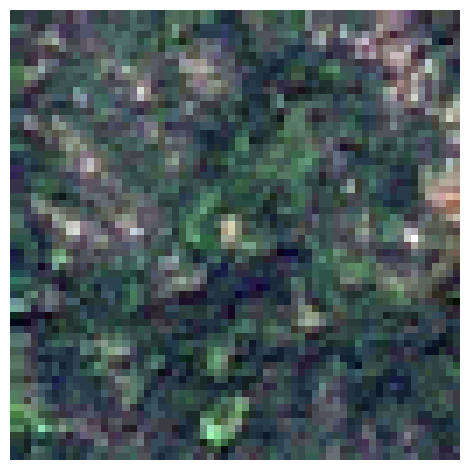

In [6]:


dataset = EuroSATDataset.download(dataset='RGB', download_dir=Path("/content/gdrive/MyDrive"))
print(dataset.classes)
torchshow.show(dataset[0]['image'])

Dataset already saved in /content/gdrive/MyDrive/MS.zip - not overwriting
Dataset already extracted to /content/gdrive/MyDrive/MS - not overwriting
['Forest', 'River', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']
{'image': tensor([[[0.1786, 0.1786, 0.2143,  ..., 0.6429, 0.6429, 0.6429],
         [0.1786, 0.1786, 0.2143,  ..., 0.6429, 0.6429, 0.6429],
         [0.2143, 0.2143, 0.2500,  ..., 0.6429, 0.6429, 0.6071],
         ...,
         [0.6071, 0.6071, 0.6429,  ..., 0.8214, 0.7857, 0.7500],
         [0.6071, 0.6071, 0.6071,  ..., 0.8214, 0.7857, 0.7500],
         [0.5714, 0.5714, 0.6071,  ..., 0.8571, 0.8214, 0.7857]],

        [[0.2949, 0.2949, 0.2488,  ..., 0.3041, 0.3226, 0.2719],
         [0.2949, 0.2949, 0.2488,  ..., 0.3041, 0.3226, 0.2719],
         [0.2350, 0.2350, 0.1797,  ..., 0.3594, 0.3364, 0.2120],
         ...,
         [0.3180, 0.3180, 0.5806,  ..., 0.3594, 0.4608, 0.3917],
         [0.4562, 0.4562,

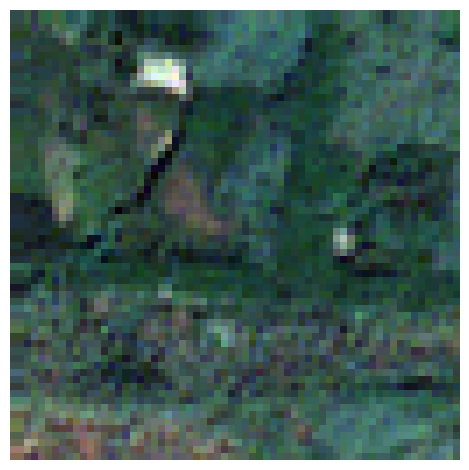

In [7]:
dataset = EuroSATDataset.download(dataset='MS', download_dir=Path("/content/gdrive/MyDrive"))
print(dataset.classes)
print(dataset[0])
torchshow.show(dataset[0]['image'][[3,2,1]])

In [30]:
import torchvision.models as models

net = models.resnet18(pretrained=True)

tr_train = transforms.Compose(
    [
        # transforms.v2.RGB(),
        transforms.RandomResizedCrop((128, 128)),
        transforms.RandomHorizontalFlip(),
        # transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)

tr_val = transforms.Compose(
    [
        # transforms.v2.RGB(),
        transforms.Resize((128, 128)),
        # transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


print(torchinfo.summary(net, input_size=(1, 3, 64, 64)))


net.fc = nn.Sequential(nn.Linear(512, 10))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 32, 32]           9,408
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 64, 16, 16]           --
│    └─BasicBlock: 2-1                   [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-3                    [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-4                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-6                    [1, 64, 16, 16]           --
│

In [41]:

ids = [i for i in range(0, len(dataset.observations))]
labels = [x["label"] for x in dataset.observations]

train_ids, test_ids = train_test_split(ids, train_size=0.8, stratify=labels)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, stratify=[labels[i] for i in test_ids])

dataset_train = EuroSATDataset.from_subset(dataset, train_ids, tr_train)
dataset_val = EuroSATDataset.from_subset(dataset, val_ids, tr_val)
dataset_test = EuroSATDataset.from_subset(dataset, test_ids)

dataloader_train = DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=os.cpu_count())
dataloader_val = DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=os.cpu_count())
dataloader_test = DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=os.cpu_count())

Created a subset with 21_600 of 27_000 images
Created a subset with 2_700 of 27_000 images
Created a subset with 2_700 of 27_000 images


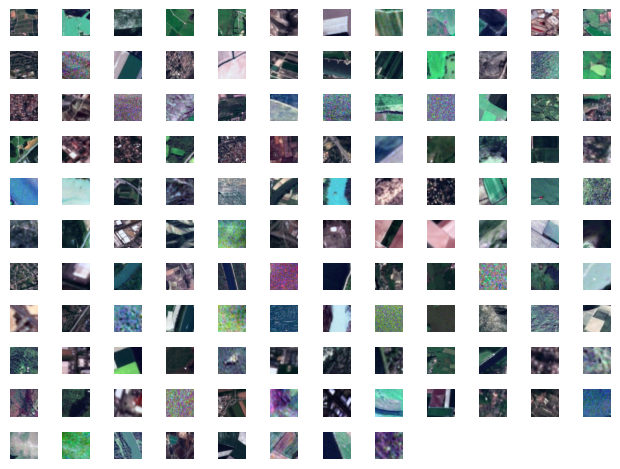

In [42]:
observations = next(iter(dataloader_train))
torchshow.show(observations['image'])

In [8]:
class Classifier(L.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss()
        self.train_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=len(dataset.classes))
        self.train_loss = torchmetrics.MeanMetric()
        self.val_accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=len(dataset.classes))
        self.val_loss = torchmetrics.MeanMetric()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update accuracy metric
        self.train_accuracy(preds, y)
        self.train_loss(loss)

        self.log("train/acc_step", self.train_accuracy, prog_bar=True)
        self.log("train/loss_step", loss, prog_bar=True)

        return loss

    def on_train_epoch_end(self):
        # log epoch metric
        self.log("train/acc_epoch", self.train_accuracy)
        self.log("train/loss_epoch", self.train_loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch["image"], batch["label"]
        logits = self(x)
        loss = self.loss_fn(logits, y)
        preds = torch.argmax(logits, dim=1)

        # Update accuracy metric
        self.val_accuracy(preds, y)
        self.val_loss(loss)

        self.log("val/acc_step", self.val_accuracy, prog_bar=True)
        self.log("val/loss_step", self.val_loss, prog_bar=True)

        return loss

    def on_validation_epoch_end(self):
      self.log("val/acc_epoch", self.val_accuracy)
      self.log("val/loss_epoch", self.val_loss)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [12]:
trainer = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_epochs=30,
    # max_steps=150,
    enable_checkpointing=False,
)

model = Classifier(net)

trainer.fit(model, train_dataloaders=dataloader_train, val_dataloaders=dataloader_val)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


NameError: name 'net' is not defined

In [44]:
trainer.logged_metrics

{'train/acc_step': tensor(0.9688),
 'train/loss_step': tensor(0.1433),
 'val/acc_step': tensor(0.9430),
 'val/loss_step': tensor(0.1741),
 'val/acc_epoch': tensor(0.9430),
 'val/loss_epoch': tensor(0.1741),
 'train/acc_epoch': tensor(0.9475),
 'train/loss_epoch': tensor(0.1551)}

In [56]:
model.eval()

predictions = []
labels = []
missclassified = []
dl_val = DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=5)
with torch.no_grad():
  for batch in dl_val:
    y_true = batch['label'].tolist()
    logits = model(batch['image'])
    y_pred = torch.argmax(logits, dim=1).tolist()
    labels.extend(y_true)
    predictions.extend(y_pred)

    for ix in range(len(batch['label'])):
      if y_true[ix] != y_pred[ix]:
        missclassified.append({'image': batch['image'][ix], 'true': y_true[ix], 'prediction': y_pred[ix]})

In [57]:

selection = list(filter(lambda o: o['true'] == 0, missclassified))
selection

[{'image': tensor([[[-1.7463, -1.7463, -1.7463,  ..., -1.8159, -1.7695, -1.7463],
           [-1.7463, -1.7463, -1.7463,  ..., -1.8247, -1.7956, -1.7811],
           [-1.7463, -1.7463, -1.7463,  ..., -1.8421, -1.8479, -1.8508],
           ...,
           [-1.6650, -1.6679, -1.6737,  ..., -1.8972, -1.8972, -1.8972],
           [-1.6882, -1.6969, -1.7143,  ..., -1.9205, -1.9205, -1.9205],
           [-1.6998, -1.7114, -1.7346,  ..., -1.9321, -1.9321, -1.9321]],
  
          [[-1.6814, -1.6814, -1.6814,  ..., -1.8586, -1.7877, -1.7523],
           [-1.6814, -1.6814, -1.6814,  ..., -1.8586, -1.7877, -1.7523],
           [-1.6814, -1.6814, -1.6814,  ..., -1.8586, -1.7877, -1.7523],
           ...,
           [-1.5574, -1.5618, -1.5707,  ..., -1.7700, -1.7700, -1.7700],
           [-1.5928, -1.6061, -1.6327,  ..., -1.8054, -1.8054, -1.8054],
           [-1.6105, -1.6283, -1.6637,  ..., -1.8231, -1.8231, -1.8231]],
  
          [[-1.4341, -1.4341, -1.4341,  ..., -1.2952, -1.2026, -1.1563],
  

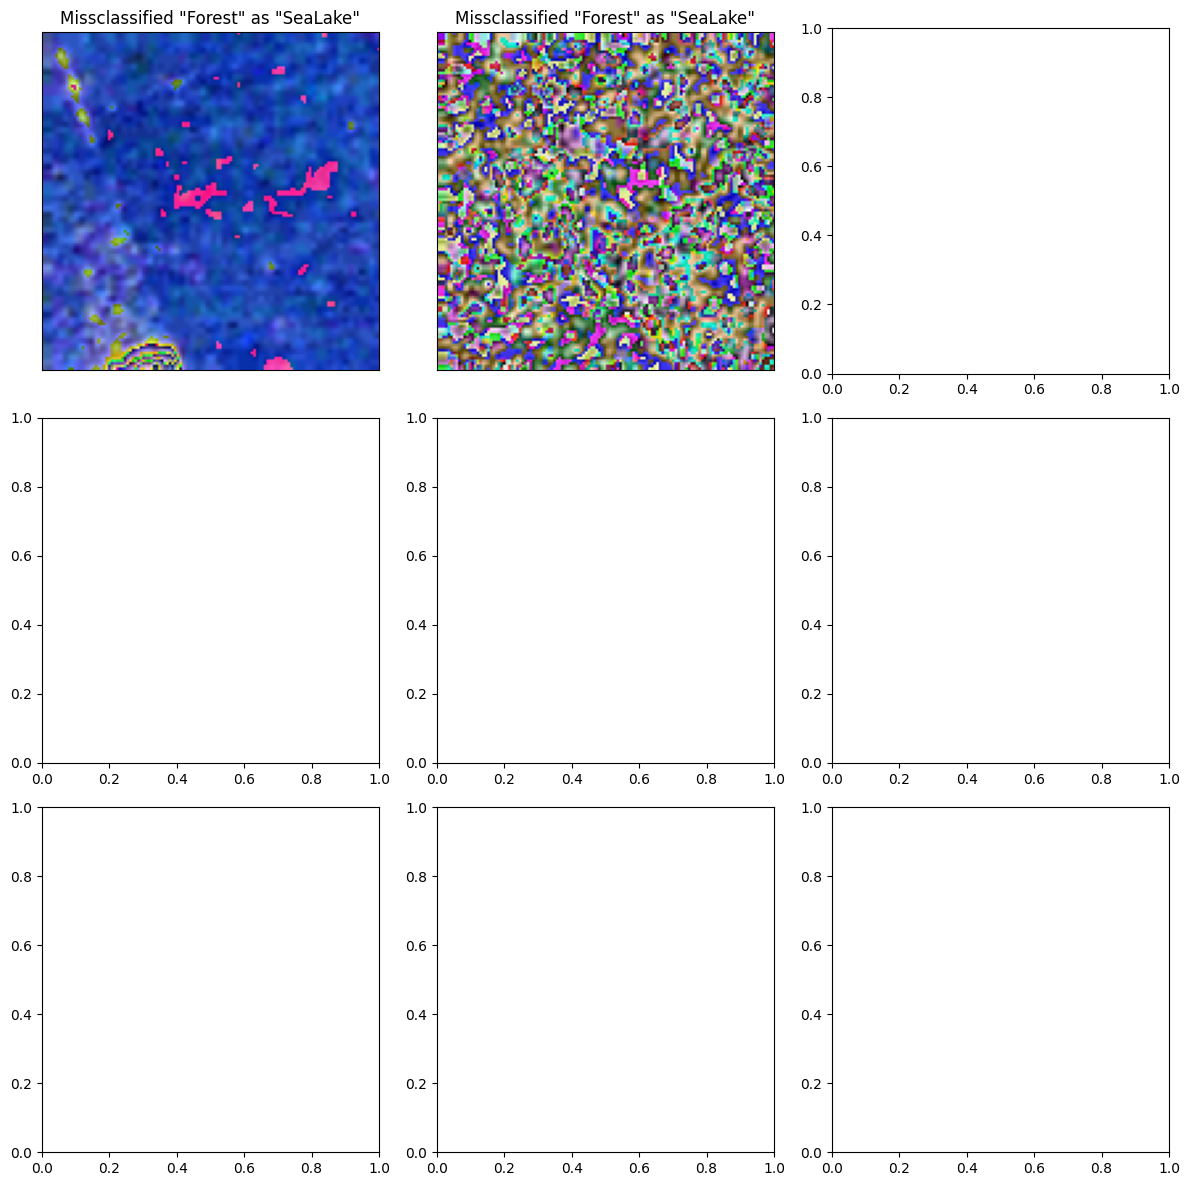

In [58]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
axs = axs.flatten()

selection = missclassified.copy()
selection = list(filter(lambda o: o['true'] == 0, missclassified))

for i, observation in enumerate(selection):
  img = transforms.functional.to_pil_image(observation['image'])
  axs[i].set_title(f'Missclassified "{dataset_val.classes[observation["true"]]}" as "{dataset_val.classes[observation["prediction"]]}"')
  axs[i].imshow(img)
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

  if i >= 9 - 1:
    break

plt.tight_layout()

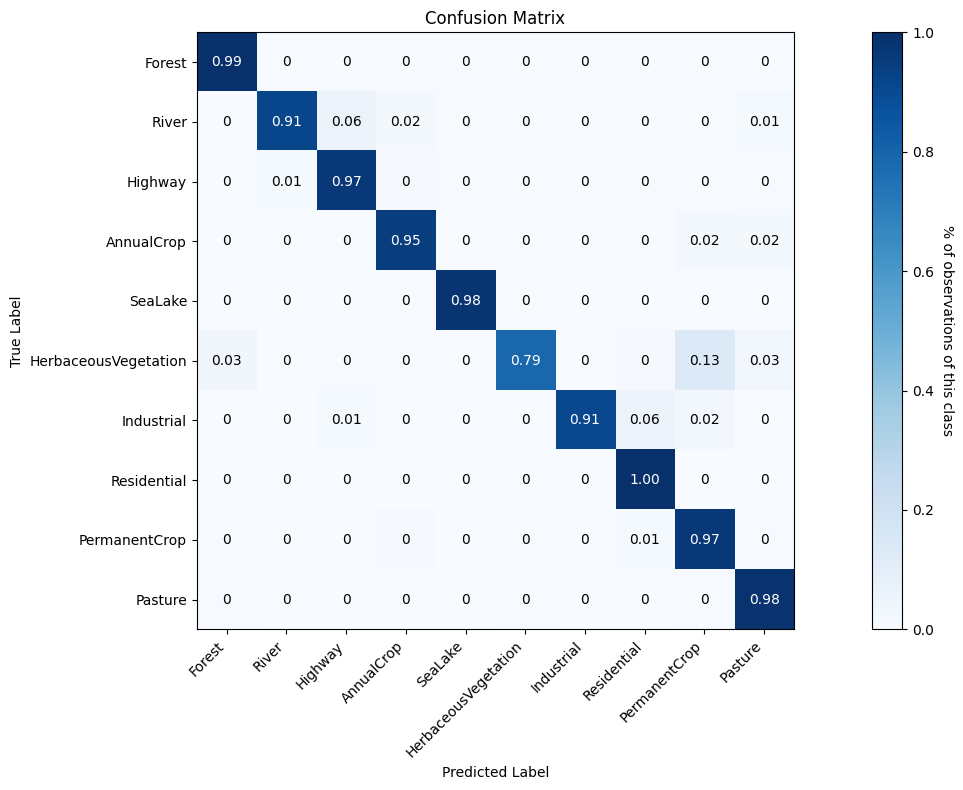

In [52]:
cm = confusion_matrix(labels, predictions, normalize='true')

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")

im = ax.imshow(cm, vmin=0., vmax=1., cmap=plt.cm.Blues)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('% of observations of this class', rotation=-90, va="bottom")

# Add text annotations inside the matrix
for i in range(len(dataset_val.classes)):
    for j in range(len(dataset_val.classes)):
        ax.text(j, i, f"{cm[i, j]:.2f}" if cm[i, j] > 0.01 else "0", ha="center", va="center", color="white" if cm[i, j] > 0.5 else "black")

tick_marks = range(len(dataset_val.classes))
ax.set_xticks(tick_marks)
ax.set_yticks(tick_marks)
ax.set_xticklabels(dataset_val.classes, rotation=45, ha="right")
ax.set_yticklabels(dataset_val.classes)

plt.tight_layout()

In [59]:
torch.save(model.state_dict(), "/content/gdrive/MyDrive/RGBResnet")

# MS

In [9]:
# Python Standard Library
import os
from pathlib import Path
import requests
from typing import Callable
from typing import Literal
import zipfile

# Third Party Libraries
from PIL import Image
import tifffile
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class EuroSATDatasetTEST(Dataset):
  def __init__(self, root_dir, transform: Callable | None = None,):
    self.root_dir = root_dir
    self.transform = transform

    self.observations = list()
    self.classes = os.listdir(root_dir)
    for label in self.classes:
        class_dir = os.path.join(root_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if any(img_path.lower().endswith(ext) for ext in ['.jpg', '.tif']):
                self.observations.append({"image_path": img_path, "label": label})

  def __len__(self):
    return len(self.observations)

  def __getitem__(self, idx):
    image_path = self.observations[idx]["image_path"]
    _ , ext = os.path.splitext(image_path)
    if ext == '.jpg':
      image = Image.open(image_path)
      image = transforms.ToTensor()(image)
    else:
      image = tifffile.imread(image_path)
      image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
      image = image[:7]


        # Handle per-channel normalization
    for channel in range(image.shape[0]):
        channel_min = image[channel].min()
        channel_max = image[channel].max()
        if channel_max != channel_min:
            image[channel] = (image[channel] - channel_min) / (channel_max - channel_min)
        else:
            image[channel] = torch.zeros_like(image[channel])  # Set to zero if uniform


    label = self.observations[idx]["label"]
    label_num = self.classes.index(label)

    if self.transform:
      image = self.transform(image)

    return {"image": image, "label": label_num}

  @classmethod
  def download(cls, dataset: Literal['RGB', 'MS'] = 'MS', download_dir: Path = Path('/workspace/code/data')):
    if dataset == 'RGB':
      url = 'https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip?download=1'
    else:
      # Multi-spectral dataset selected
      url = 'https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1'

    save_path = download_dir / f'{dataset}.zip'
    extract_path = download_dir / f'{dataset}/'

    os.makedirs(download_dir, exist_ok=True)

    if save_path.exists():
      # Zip file already downloaded and saved on local machine
      print(f"Dataset already saved in {save_path} - not overwriting")
    else:
      # Zip file is not downloaded yet
      print(f"Starting download from {url}")
      response = requests.get(url, allow_redirects=True)
      with open(save_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
          file.write(chunk)
      print(f"Dataset downloaded and saved to {save_path}")

    if extract_path.exists():
      # Zip file already extracted to local storage
      print(f"Dataset already extracted to {extract_path} - not overwriting")
    else:
      # Zip file not extracted yet
      print(f"Starting extracting dataset to {extract_path}")
      with zipfile.ZipFile(save_path, "r") as zip_ref:
        zip_ref.extractall(extract_path)
      print(f"Dataset extracted to {extract_path}")

    if dataset == 'RGB':
      return cls(root_dir=extract_path / 'EuroSAT_RGB/')
    # Else: Multi-spectral dataset selected
    return cls(root_dir=extract_path / 'EuroSAT_MS/')

  @classmethod
  def from_subset(cls, original, indices: list[int], transform: Callable | None = None):
      # Create a new instance with the same properties as the original
      subset = cls(root_dir=original.root_dir, transform=original.transform if transform is None else transform,)

      # Filter the observations based on the subset indices
      subset.observations = [original.observations[i] for i in indices]
      subset.classes = original.classes  # Keep class list consistent

      print(f'Created a subset with {len(subset.observations):_} of {len(original.observations):_} images')

      return subset

In [10]:
import torchvision.models as models

netMS = models.resnet18()

# 2. Replace the first conv layer
old_conv = netMS.conv1

# Create a new conv that has 13 input channels,
# but the same other parameters as the old conv
netMS.conv1 = nn.Conv2d(
    in_channels=13,
    out_channels=old_conv.out_channels,  # 64
    kernel_size=old_conv.kernel_size,    # (7, 7)
    stride=old_conv.stride,              # (2, 2)
    padding=old_conv.padding,            # (3, 3)
    bias=old_conv.bias is not None
)


print(torchinfo.summary(netMS, input_size=(1, 13, 64, 64)))


netMS.fc = nn.Linear(512, 10)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 1000]                 --
├─Conv2d: 1-1                            [1, 64, 32, 32]           40,768
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]           128
├─ReLU: 1-3                              [1, 64, 32, 32]           --
├─MaxPool2d: 1-4                         [1, 64, 16, 16]           --
├─Sequential: 1-5                        [1, 64, 16, 16]           --
│    └─BasicBlock: 2-1                   [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-1                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-3                    [1, 64, 16, 16]           --
│    │    └─Conv2d: 3-4                  [1, 64, 16, 16]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 16, 16]           128
│    │    └─ReLU: 3-6                    [1, 64, 16, 16]           --


Starting download from https://zenodo.org/records/7711810/files/EuroSAT_MS.zip?download=1
Dataset downloaded and saved to /workspace/code/data/MS.zip
Starting extracting dataset to /workspace/code/data/MS
Dataset extracted to /workspace/code/data/MS
['Residential', 'Highway', 'Industrial', 'HerbaceousVegetation', 'PermanentCrop', 'SeaLake', 'AnnualCrop', 'River', 'Forest', 'Pasture']
{'image': tensor([[[0.4579, 0.4579, 0.4763,  ..., 0.3684, 0.3763, 0.3842],
         [0.4579, 0.4579, 0.4763,  ..., 0.3684, 0.3763, 0.3842],
         [0.4553, 0.4553, 0.4684,  ..., 0.3553, 0.3632, 0.3737],
         ...,
         [0.2553, 0.2553, 0.2579,  ..., 0.2158, 0.2105, 0.2026],
         [0.2474, 0.2474, 0.2526,  ..., 0.2368, 0.2263, 0.2158],
         [0.2447, 0.2447, 0.2526,  ..., 0.2605, 0.2447, 0.2316]],

        [[0.1014, 0.1014, 0.0891,  ..., 0.0841, 0.1840, 0.1180],
         [0.1014, 0.1014, 0.0891,  ..., 0.0841, 0.1840, 0.1180],
         [0.0925, 0.0925, 0.1090,  ..., 0.0296, 0.0647, 0.0900],
  

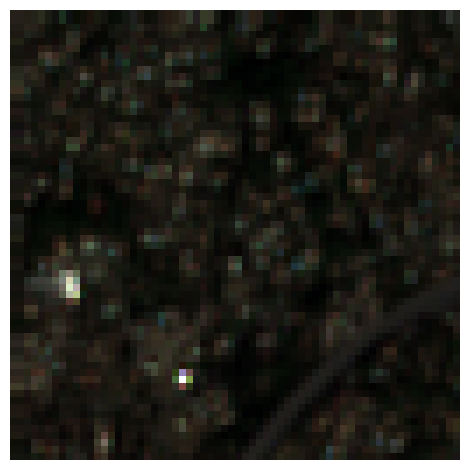

In [15]:
datasetMS = EuroSATDataset.download(dataset='MS')
print(datasetMS.classes)
print(datasetMS[0])
torchshow.show(datasetMS[0]['image'][[3,2,1]])

In [16]:
ids = [i for i in range(0, len(datasetMS.observations))]
labels = [x["label"] for x in datasetMS.observations]

train_ids, test_ids = train_test_split(ids, train_size=0.8, stratify=labels)
val_ids, test_ids = train_test_split(test_ids, test_size=0.5, stratify=[labels[i] for i in test_ids])

dataset_train_ms = EuroSATDataset.from_subset(datasetMS, train_ids)
dataset_val_ms = EuroSATDataset.from_subset(datasetMS, val_ids)
dataset_test_ms = EuroSATDataset.from_subset(datasetMS, test_ids)

dataloader_train_ms = DataLoader(dataset_train_ms, batch_size=128, shuffle=True, num_workers=os.cpu_count())
dataloader_val_ms = DataLoader(dataset_val_ms, batch_size=128, shuffle=True, num_workers=os.cpu_count())
dataloader_test_ms = DataLoader(dataset_test_ms, batch_size=128, shuffle=True, num_workers=os.cpu_count())

Created a subset with 21_600 of 27_000 images
Created a subset with 2_700 of 27_000 images
Created a subset with 2_700 of 27_000 images


In [13]:
observations_ms = next(iter(dataloader_train_ms))
# torchshow.show(observations_ms['image'])

KeyboardInterrupt: 

In [73]:
for batch in dataloader_val_ms:
    images = batch["image"]
    labels = batch["label"]
    if torch.isnan(images).any():
        print("NaN found in images")
    if torch.isnan(labels).any():
        print("NaN found in labels")
    break

In [75]:
for idx in range(10):  # Check the first 10 samples
    sample = dataset_test_ms[idx]
    image, label = sample["image"], sample["label"]
    print(f"Sample {idx}: min={image.min()}, max={image.max()}, mean={image.mean()}")

Sample 0: min=0.0, max=1.0, mean=0.5063577890396118
Sample 1: min=0.0, max=1.0, mean=0.4560874104499817
Sample 2: min=0.0, max=1.0, mean=0.47802433371543884
Sample 3: min=0.0, max=1.0, mean=0.39469730854034424
Sample 4: min=0.0, max=1.0, mean=0.43473750352859497
Sample 5: min=0.0, max=1.0, mean=0.39535045623779297
Sample 6: min=0.0, max=1.0, mean=0.5630617141723633
Sample 7: min=0.0, max=1.0, mean=0.48593762516975403
Sample 8: min=0.0, max=1.0, mean=0.36642229557037354
Sample 9: min=0.0, max=1.0, mean=0.4207642376422882


In [17]:
trainerMS = L.Trainer(
    devices="auto",
    accelerator="auto",
    precision="32",
    max_epochs=30,
    # max_steps=150,
    enable_checkpointing=False,
)

modelMS = Classifier(netMS)

trainerMS.fit(modelMS, train_dataloaders=dataloader_train_ms, val_dataloaders=dataloader_val_ms)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | model          | ResNet             | 11.2 M | train
1 | loss_fn        | CrossEntropyLoss   | 0      | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | train_loss     | MeanMetric         | 0      | train
4 | val_accuracy   | MulticlassAccuracy | 0      | train
5 | val_loss       | MeanMetric         | 0      | train
---------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=30` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [15]:
test = torch.tensor(True)
test

if test:
  print("Test")
else:
  print("NOt")

Test
